# Comparing structure and spectra of stable and unstable neural networks

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from uwnet.wave import model_plus_damping, wave_from_xarray, plot_struct_2d
import torch
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from uwnet import thermo
from src.data import open_data


def sortbyvalue(eig):
    cp = eig.value.imag
    gr = eig.value.real
    permutation = cp *100 + gr
    return eig.sortby(permutation)


def get_eigen_pair_xarray(wave, k):
    lam, r = wave.get_eigen_pair(k=k)
    return xr.Dataset({'value': (['m'], lam), 'vector':(['f', 'm'], r)}, coords={'k': k})


def get_spectrum(wave):
    k = 2*np.pi * np.r_[:128] / 40e6
    eigs = [get_eigen_pair_xarray(wave, kk) for kk in k]
    return xr.concat(eigs, dim='k')


def get_sorted_spectrum(wave):
    eig = get_spectrum(wave)
    return eig.groupby('k').apply(sortbyvalue)


def plot_struct_x(eig):

    cp = eig.value.imag/eig.k
    targ = 20
    i = np.abs(cp - targ).argmin()
    eig = eig.isel(m=i)
    plot_struct_eig(eig)
    
    
def plot_struct_eig(eig):

    w, s, q = np.split(eig.vector, 3)
    fig, (a, b, c) = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True)
    
    a.set_title('W')
    im = plot_struct_2d(w.values, mean.z.values, ax=a)
    plt.colorbar(im, ax=a, fraction=.05)

    b.set_title('S')
    im = plot_struct_2d(s.values, mean.z.values, ax=b)
    plt.colorbar(im, ax=b, fraction=.05)

    c.set_title('Q')
    im = plot_struct_2d(q.values, mean.z.values, ax=c)
    plt.colorbar(im, ax=c, fraction=.05)
    
    cp = float(eig.value.imag/eig.k)
    gr = 86400 * float(eig.value.real)
    
    fig.suptitle(f"cp = {cp:.2f} m/s; gr = {gr:.2f} 1/d")
    
    
def most_unstable(eig, c=100):
    cp = eig.value.imag/eig.k
    m = int(np.abs(cp-c).argmin())
    return eig.isel(m=m)


def scatter_spectra(eig):
    cp = eig.value.imag/eig.k
    gr = eig.value.real * 86400

    cp, gr, k = [_.values.ravel() for _ in xr.broadcast(cp, gr, eig.k)]

    plt.scatter(cp , gr, c=plt.cm.Blues(k/k.max()), s=.5)
    plt.ylim(gr.min(), gr.max())
    plt.yscale('symlog', linthreshy=.1)

    
def get_spectra_for_path(path):

    model = torch.load(path)
    src_original = model_plus_damping(model)
    wave = wave_from_xarray(mean, src=src_original)
    eig = get_spectrum(wave)

    return eig

/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
ds = open_data('training')
mean = ds.isel(y=slice(28, 34)).mean(['x', 'y', 'time'])
# mean['time_of_day'] = mean['time'] % 1

As you can see wee, get different answer for different values of SOLIN, and for the marginalized solution.

# Spectra

In [3]:
eig_no_penalty = get_spectra_for_path("../models/280/5.pkl")
eig_unsable = get_spectra_for_path("../models/282/5.pkl")
eig = get_spectra_for_path("../models/268/5.pkl")

/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'uwnet.normalization.Scaler' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.container.ParameterDict' has changed. you can retrieve the or

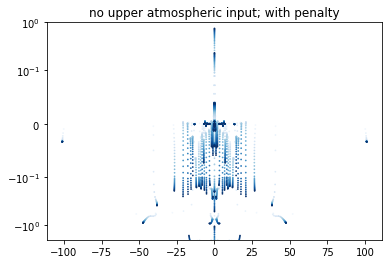

In [4]:
scatter_spectra(eig.isel(k=slice(0,32)))
plt.ylim(-2, 1)
plt.title("no upper atmospheric input; with penalty");
# plt.xlim(-50, 50)

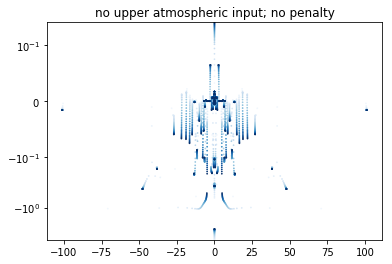

In [5]:
scatter_spectra(eig_no_penalty.isel(k=slice(0,32)))
plt.title("no upper atmospheric input; no penalty");
# plt.ylim(-2, 1)
# plt.xlim(-50, 50)

the instability penalty does not make much difference.

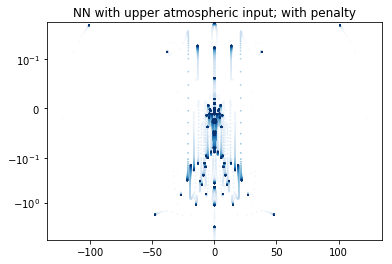

In [6]:
scatter_spectra(eig_unsable)
plt.title("NN with upper atmospheric input; with penalty");

The unstable model has numerous large propagating instabilities

# Structure of fastest wave

In [7]:
k = -1

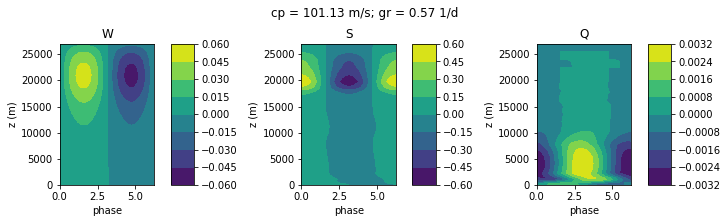

In [8]:
plot_struct_eig(most_unstable(eig_unsable.isel(k=k)))

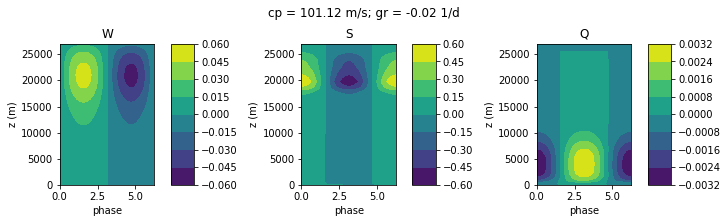

In [9]:
plot_struct_eig(most_unstable(eig_no_penalty.isel(k=k)))

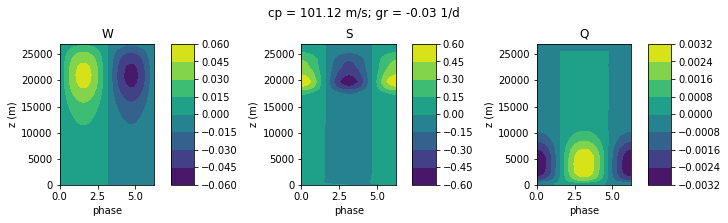

In [10]:
plot_struct_eig(most_unstable(eig.isel(k=k)))

The wave with the 100 m/s speed has a positive growth rate for the NN w/ upper atmospheric inputs.